In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = "../data/rfc_vs_4fgl_dr4.txt"

In [3]:
def cs(a, b):
    return (a - 1, b)

colspecs = [
    cs(1, 8),      # Bname
    cs(10, 19),    # Jname

    cs(22, 23),    # VLBI RA hour
    cs(25, 26),    # VLBI RA min
    cs(28, 36),    # VLBI RA sec

    cs(38, 38),    # VLBI Dec sign
    cs(39, 40),    # VLBI Dec deg
    cs(42, 43),    # VLBI Dec arcmin
    cs(45, 52),    # VLBI Dec arcsec

    cs(57, 73),    # Fermi name
    cs(76, 80),    # Nsig
    cs(84, 88),    # Dist (arcmin)
]


names = [
    "Bname", "Jname",
    "vlbi_ra_h", "vlbi_ra_m", "vlbi_ra_s",
    "vlbi_dec_sign", "vlbi_dec_deg", "vlbi_dec_arcmin", "vlbi_dec_arcsec",
    "fermi_name", "nsig", "dist_arcmin",
]

In [4]:
fermi = pd.read_fwf(
    path,
    colspecs=colspecs,
    names=names,
    comment="#",
    header=None
)
fermi.head()

,Bname,Jname,vlbi_ra_h,vlbi_ra_m,vlbi_ra_s,vlbi_dec_sign,vlbi_dec_deg,vlbi_dec_arcmin,vlbi_dec_arcsec,fermi_name,nsig,dist_arcmin
0,2358+474,J0001+4742,0,1,19.041802,+,47,42,0.72074,4FGL J0001.2+4741,0.829,1.095
1,2358-080,J0001-0746,0,1,18.024917,-,7,46,26.92209,4FGL J0001.2-0747,2.099,1.503
2,2358-004,J0001-0011,0,1,21.466915,-,0,11,40.31503,4FGL J0001.4-0010,1.683,2.434
3,2358+209,J0001+2113,0,1,32.370489,+,21,13,36.27481,4FGL J0001.5+2113,0.562,0.537
4,2358-422,J0001-4155,0,1,32.757127,-,41,55,25.33111,4FGL J0001.6-4156,1.355,1.757


In [5]:
classification = pd.read_csv("/home/zagorulia/ml/classification.csv", index_col=0)

In [6]:
sources = [file.split('_')[0] for file in classification.file.tolist()]
classification['source'] = sources

In [7]:
classification.head()

,file,prob,pred,source
0,J0000+0248_C_2016_01_03_pet_map.fits,0.000089,0,J0000+0248
1,J0000+0248_S_2022_01_07_pet_map.fits,0.000024,0,J0000+0248
2,J0000+0248_X_2016_01_03_pet_map.fits,0.081690,0,J0000+0248
3,J0000+0248_X_2022_01_07_pet_map.fits,0.001513,0,J0000+0248
4,J0000+0307_C_2015_12_23_pet_map.fits,0.027874,0,J0000+0307


In [8]:
agg = (
    classification
    .groupby("source", as_index=False)
    .agg(
        mean_prob=("prob", "mean"),
        mean_pred=("pred", "mean"),
        n=("prob", "size"),
    )
)
agg.head()

,source,mean_prob,mean_pred,n
0,J0000+0248,0.020829,0.000000,4
1,J0000+0307,0.317720,0.285714,7
2,J0000+030B,0.243774,0.333333,3
3,J0000+0816,0.999955,1.000000,1
4,J0000+1139,0.499542,0.500000,2


In [9]:
final = (
    fermi
    .merge(agg, left_on="Jname", right_on="source", how="left")
    .drop(columns="source")
)
print(final.mean_prob.isna().sum(), final.mean_pred.isna().sum())
final = final.rename(columns={"mean_prob": "probability"})
final_no_na = final.dropna().copy()
final_no_na["pred"] = (final_no_na["probability"] >= 0.5).astype("int64")
counts, bin_edges = np.histogram(final_no_na["pred"].dropna(), bins=2)
print(counts, max(counts) / sum(counts))

263 263
[1739 1167] 0.5984170681348934


Text(0.5, 1.0, 'Distribution of Mean Probability for Fermi & VLBI Associated Sources')

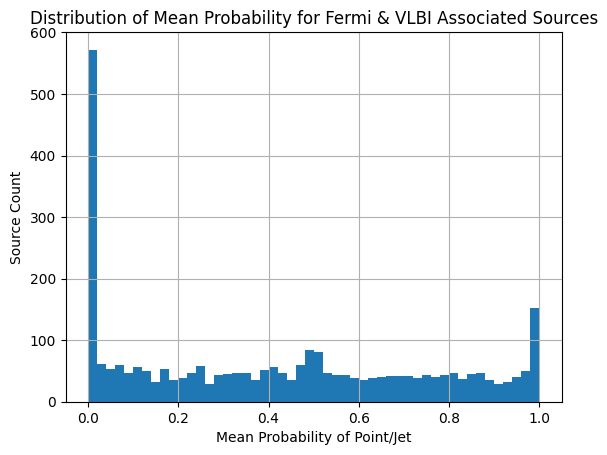

In [10]:
final_no_na["probability"].hist(bins=50)
plt.xlabel("Mean Probability of Point/Jet")
plt.ylabel("Source Count")
plt.title("Distribution of Mean Probability for Fermi & VLBI Associated Sources")

In [11]:
# final[["Jname", "probability", "fermi_name"]].to_csv("morph_rfc_fermi_ass.csv", index=False)

In [12]:
na_df = final[
    final["probability"].isna() & final["mean_pred"].isna()
].reset_index(drop=True)

In [13]:
na_df[["Jname", "probability", "mean_pred"]].head()

,Jname,probability,mean_pred
0,J0001-4155,NaN,NaN
1,J0002-6726,NaN,NaN
2,J0009-6357,NaN,NaN
3,J0011-4105,NaN,NaN
4,J0014-5022,NaN,NaN


In [14]:
def ra_diff(a, b):
    d = np.abs(a - b)
    return np.minimum(d, 24 * 60 - d)

def dec_diff(a, b):
    d = np.abs(a - b)
    return np.minimum(d, 360 * 60 - d)

def parse_jname(j):
    # J0001-4155 → (1, -4155)
    ra = 60 * int(j[1:3]) + int(j[3:5])
    sign = -1 if j[5] == "-" else 1
    try:
        dec = sign * (60 * int(j[6:8]) + int(j[8:10]))
    except ValueError:
        return float("inf"), float("inf")
    return ra, dec

def closest_jname(query, candidates):
    q_ra, q_dec = parse_jname(query)
    best = None
    best_d = float("inf")

    for c in candidates:
        ra, dec = parse_jname(c)
        dra = ra_diff(ra, q_ra)
        dda = dec_diff(dec, q_dec)
        d = np.hypot(dra, dda)
        if d < best_d:
            best = c
            best_d = d

    return best, best_d

In [15]:
fermi_names = np.sort(classification["source"].astype(str).values)

na_df[["closest_Jname", "closest_dist"]] = (
    na_df["Jname"]
    .apply(lambda x: pd.Series(closest_jname(x, fermi_names)))
)
# ~ 3 min

In [16]:
na_df[["Jname", "probability", "pred", "closest_Jname", "closest_dist"]].head(13)

KeyError: "['pred'] not in index"

In [ ]:
na_df["closest_dist"].replace([np.inf, -np.inf], np.nan).max()

np.float64(250.64716236175505)

In [ ]:
# na_df[["Jname", "mean_prob", "mean_pred", "closest_Jname", "closest_dist"]].to_csv('not_in_astrogeo.csv')

In [ ]:
closest_jname("J0001-4155", ["J0003-4155", "J0002-4155", "J0001-4156", "J0001-4157", "J0001-4158"])

('J0002-4155', np.float64(1.0))